In [323]:
setwd("G:\\My Drive\\SDM_China")
library("rstan")
library(gdata)
#library(bayesplot)
library(raster)
library(rgdal)
library(sp)
library(spdep)


In [324]:
### First use small dataset (but at the end change to 2):
china<-readOGR(dsn = "raw_data\\CHN_adm", layer = "CHN_adm2")
### Load data on buckwheat production in China:
#buckwheat<-raster("data\\buckwheat_production\\china\\buckwheat_HarvestedAreaFraction.tif")
#temperature<-raster("data\\environmental\\china\\wc2.0_bio_5m_09.tif")

OGR data source with driver: ESRI Shapefile 
Source: "G:\My Drive\SDM_China\raw_data\CHN_adm", layer: "CHN_adm2"
with 344 features
It has 11 fields
Integer64 fields read as strings:  ID_0 ID_1 ID_2 


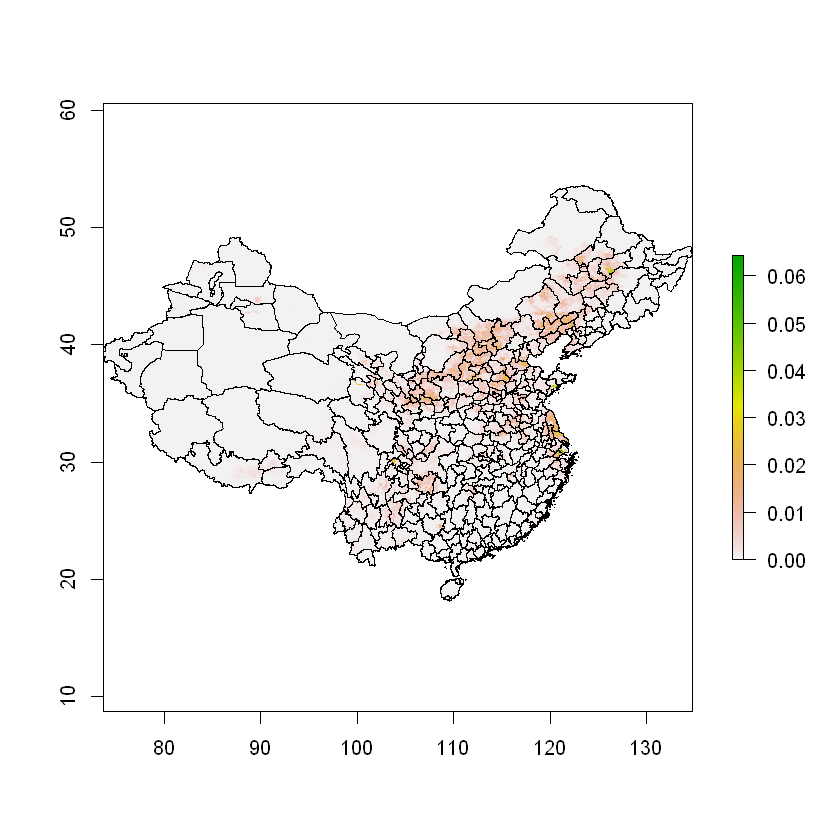

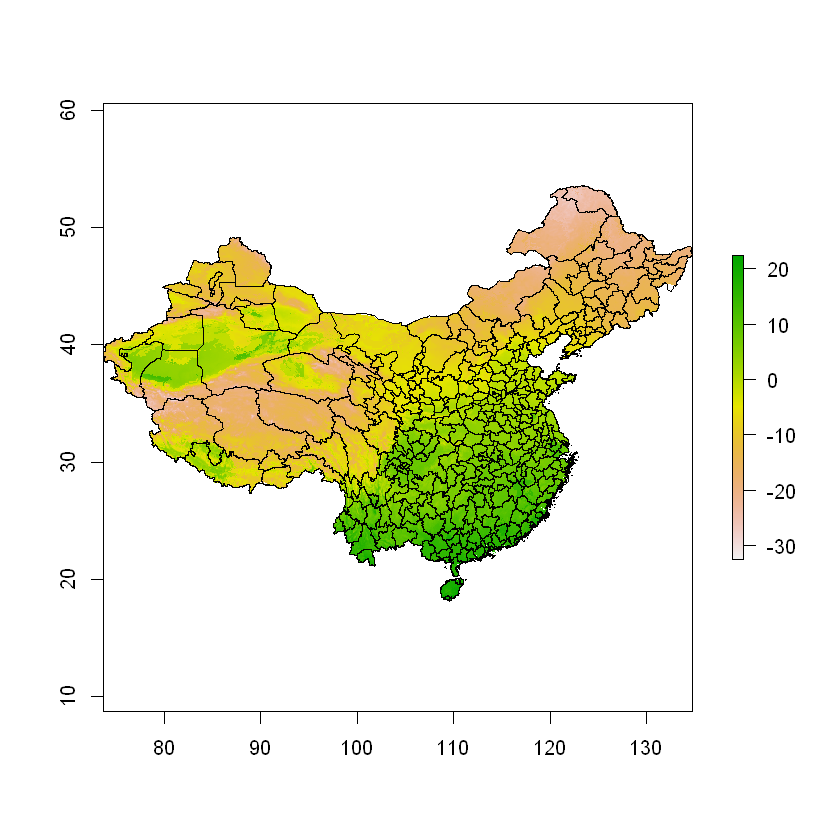

In [325]:
plot(buckwheat)
plot(china,add=TRUE)
plot(temperature)
plot(china,add=TRUE)

In [326]:
# Extract raster values to list object
r.vals <- extract(temperature,china )
# Calculates mean temperature across the polygon
r.mean <- unlist(lapply(r.vals, FUN=mean,na.rm=TRUE))
# Connect the data.frames
china@data <- data.frame(china@data, mean_temperature=r.mean)

In [327]:
# Extract raster values to list object
r.vals <- extract(buckwheat,china )
# Calculates mean temperature across the polygon
r.mean <- unlist(lapply(r.vals, FUN=mean,na.rm=TRUE))
# Connect the data.frames
china@data <- data.frame(china@data, buckwheat=r.mean)

In [328]:
head(china@data)

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,mean_temperature,buckwheat
0,49,CHN,China,1,Anhui,1,Anqing,DÃ¬jÃ­shÃ¬,Prefecture City,å®‰åº†å¸‚,Ä€nqÃ¬ng,6.034224,0.0002151057
1,49,CHN,China,1,Anhui,2,Bengbu,DÃ¬jÃ­shÃ¬,Prefecture City,èšŒåŸ å¸‚,BÃ¨ngbÃ¹,3.177524,0.0025798056
2,49,CHN,China,1,Anhui,3,Bozhou,DÃ¬jÃ­shÃ¬,Prefecture City,äº³å·žå¸‚,BÃ³zhÅu,2.875699,0.0072289328
3,49,CHN,China,1,Anhui,4,Chaohu,DÃ¬jÃ­shÃ¬,Prefecture City,å·¢æ¹–å¸‚,ChÃ¡ohÃº,4.627623,0.0007953075
4,49,CHN,China,1,Anhui,5,Chizhou,DÃ¬jÃ­shÃ¬,Prefecture City,æ± å·žå¸‚,ChÃ­zhÅu,7.001388,0.0001489681
5,49,CHN,China,1,Anhui,6,Chuzhou,DÃ¬jÃ­shÃ¬,Prefecture City,æ»å·žå¸‚,ChÃºzhÅu,3.549960,0.0015666176


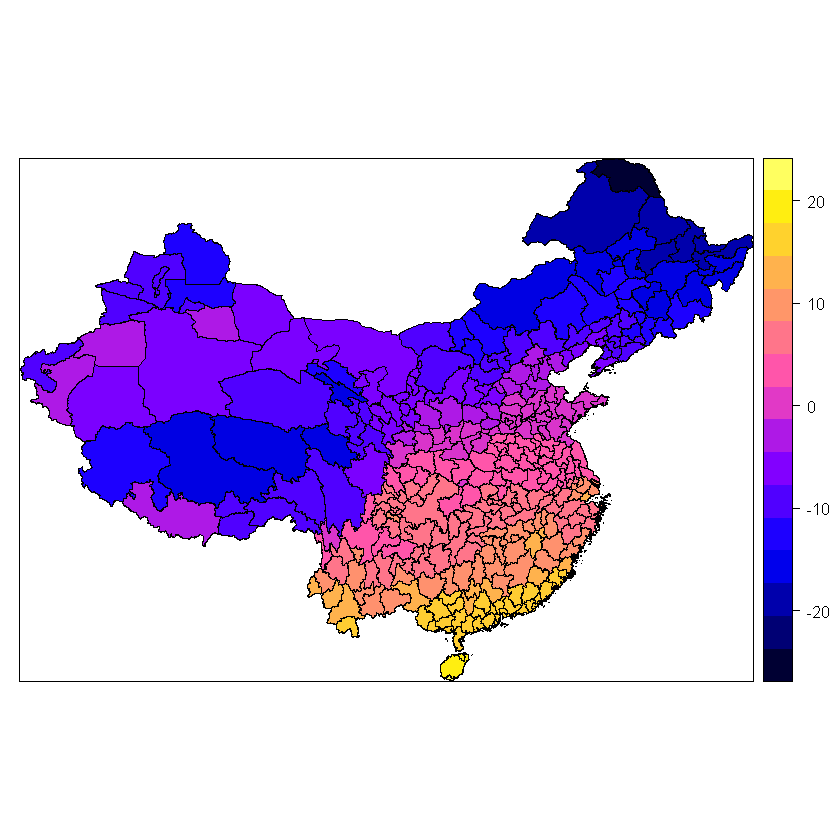

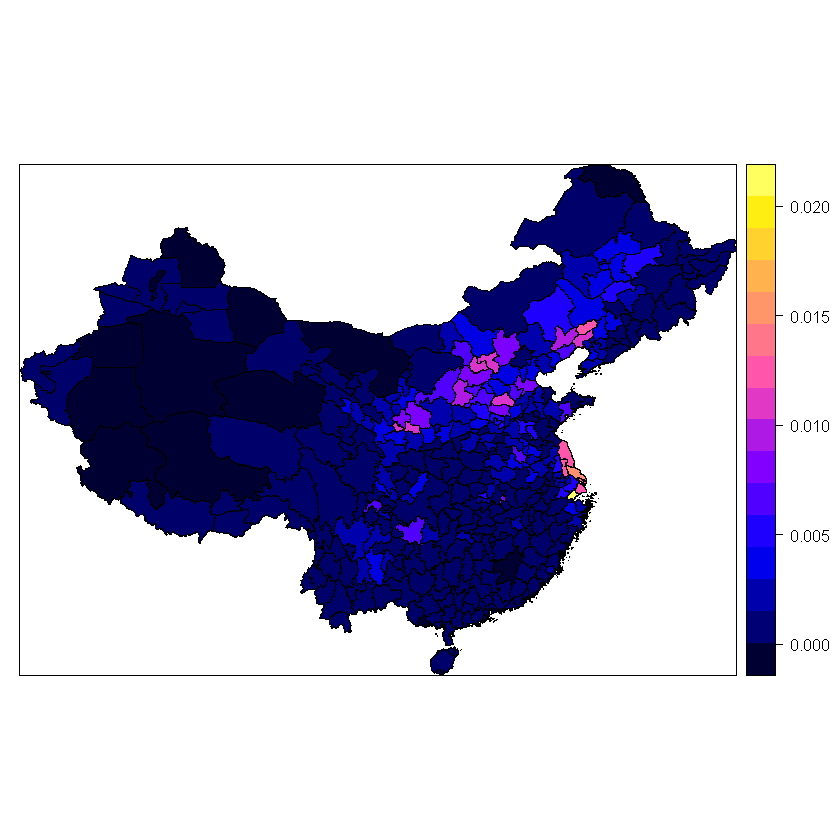

In [329]:
spplot(china['mean_temperature'] )
spplot(china['buckwheat'] )

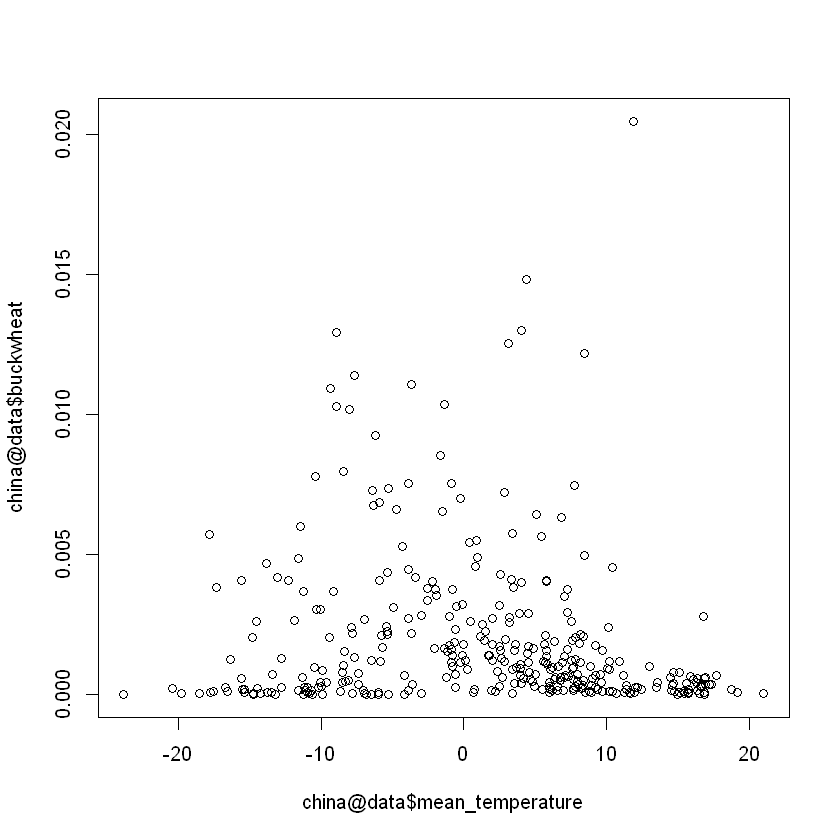

In [330]:
plot(china@data$buckwheat~china@data$mean_temperature)

# Making a simple Stan model:

In [331]:
x <- china@data$mean_temperature # Independent variable - temperature, etc.
y <- china@data$buckwheat # Dependent variable  - buckwheat production
N <- length(china@data$buckwheat) # Number of observations

In [87]:
# First make regural lm model
lm1 <- lm(y ~ x)
summary(lm1)



Call:
lm(formula = y ~ x)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0031180 -0.0014720 -0.0008778  0.0004823  0.0189702 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.050e-03  1.513e-04  13.552  < 2e-16 ***
x           -4.515e-05  1.591e-05  -2.838  0.00481 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.002774 on 342 degrees of freedom
Multiple R-squared:  0.02301,	Adjusted R-squared:  0.02016 
F-statistic: 8.056 on 1 and 342 DF,  p-value: 0.004806


In [88]:
(lm_alpha <- summary(lm1)$coeff[1])  # the intercept
(lm_beta <- summary(lm1)$coeff[2])  # the slope
(lm_sigma <- sigma(lm1))  # the residual error

[1] 0.00205014

[1] -4.515478e-05

[1] 0.002774462

In [332]:
stan_data <- list(N = N, x = x, y = y)

In [333]:
str(N)
str(x)
str(y)

 int 344
 num [1:344] 6.03 3.18 2.88 4.63 7 ...
 num [1:344] 0.000215 0.00258 0.007229 0.000795 0.000149 ...


In [334]:
str(stan_data)

List of 3
 $ N: int 344
 $ x: num [1:344] 6.03 3.18 2.88 4.63 7 ...
 $ y: num [1:344] 0.000215 0.00258 0.007229 0.000795 0.000149 ...


In [335]:
write("// Stan model for simple linear regression

data {
 int < lower = 1 > N; // Sample size is an integer with the lowest value of 1 (i.e. positive)
 vector[N] x; // Predictor is a vector of the size of sample size
 vector[N] y; // Outcome is a vector of a size of sample size
}

parameters {
 real alpha; // Intercept is an unconstrained continous value
 real beta; // Slope (regression coefficients) is an unconstrained continous value
 real < lower = 0 > sigma; // Error SD is an unconstrained positive continous valeu
}

model {
 y ~ normal(alpha + x * beta , sigma); //this seem to declare the model
}
generated quantities {
} // The posterior predictive distribution",

"stan_models\\buckwheat_model_simple1.stan")

In [336]:
stan_model1 <- "stan_models\\buckwheat_model_simple1.stan"

In [337]:
fit <- stan(file = stan_model1, data = stan_data, warmup = 500, iter = 1000, chains = 4, cores = 2, thin = 1)

Warning message:
"There were 2 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

In [338]:
fit

Inference for Stan model: buckwheat_model_simple1.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff Rhat
alpha    0.00    0.00 0.00    0.00    0.00    0.00    0.00    0.00  1038 1.00
beta     0.00    0.00 0.00    0.00    0.00    0.00    0.00    0.00  2156 1.00
sigma    0.00    0.00 0.00    0.00    0.00    0.00    0.00    0.00   204 1.04
lp__  1846.86    0.05 1.19 1843.72 1846.28 1847.15 1847.72 1848.25   495 1.00

Samples were drawn using NUTS(diag_e) at Thu Oct 03 00:44:20 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [105]:
posterior <- rstan::extract(fit)
str(posterior)

List of 4
 $ alpha: num [1:2000(1d)] 0.00229 0.00206 0.00212 0.00196 0.00205 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL
 $ beta : num [1:2000(1d)] -3.94e-05 -6.73e-05 -4.37e-05 -3.95e-05 -6.04e-05 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL
 $ sigma: num [1:2000(1d)] 0.00301 0.00276 0.00276 0.00283 0.00296 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL
 $ lp__ : num [1:2000(1d)] 1845 1847 1848 1848 1846 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL


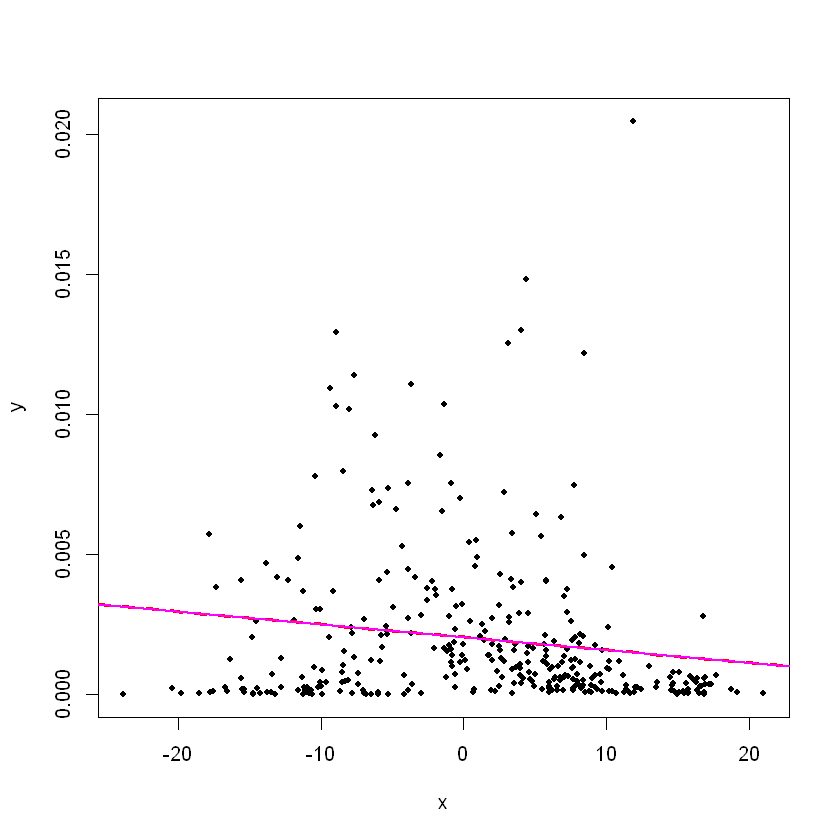

In [108]:
plot(y ~ x, pch = 20)

abline(lm1, col = 2, lty = 2, lw = 3)
abline( mean(posterior$alpha), mean(posterior$beta), col = 6, lw = 2)

In [112]:
mean(posterior$alpha)
mean(posterior$beta)
mean(posterior$sigma)

[1] 0.002045122

[1] -4.558843e-05

[1] 0.002790167

- [x] Successfully replicated the simple linear model:


Try to make a parabola model:

In [114]:
# First make regural lm model
lm2 <- lm(y ~ x +I(x^2))
summary(lm2)



Call:
lm(formula = y ~ x + I(x^2))

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0027206 -0.0015703 -0.0007767  0.0004638  0.0192984 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.684e-03  1.987e-04  13.510  < 2e-16 ***
x           -4.202e-05  1.545e-05  -2.720  0.00686 ** 
I(x^2)      -7.063e-06  1.492e-06  -4.735 3.22e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.002691 on 341 degrees of freedom
Multiple R-squared:  0.08329,	Adjusted R-squared:  0.07791 
F-statistic: 15.49 on 2 and 341 DF,  p-value: 3.639e-07


In [118]:
write("// Stan model for simple linear regression

data {
 int < lower = 1 > N; // Sample size is an integer with the lowest value of 1 (i.e. positive)
 vector[N] x; // Predictor is a vector of the size of sample size
 vector[N] y; // Outcome is a vector of a size of sample size
}

parameters {
 real alpha; // Intercept is an unconstrained continous value
 real beta; // Slope (regression coefficients) is an unconstrained continous value
 real beta2; // Slope (regression coefficients) is an unconstrained continous value
 real < lower = 0 > sigma; // Error SD is an unconstrained positive continous valeu
}

model {
 y ~ normal(alpha + x * beta + square(x) * beta2 , sigma); //this seem to declare the model
}
generated quantities {
} // The posterior predictive distribution",

"stan_models\\buckwheat_model_simple2.stan")

In [119]:
stan_model1 <- "stan_models\\buckwheat_model_simple2.stan"

In [120]:
fit <- stan(file = stan_model1, data = stan_data, warmup = 500, iter = 1000, chains = 4, cores = 2, thin = 1)

Warning message:
"There were 304 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

In [121]:
fit

Inference for Stan model: buckwheat_model_simple2.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff Rhat
alpha    0.00    0.00 0.00    0.00    0.00    0.00    0.00    0.00   562 1.00
beta     0.00    0.00 0.00    0.00    0.00    0.00    0.00    0.00  1697 1.00
beta2    0.00    0.00 0.00    0.00    0.00    0.00    0.00    0.00   921 1.00
sigma    0.00    0.00 0.00    0.00    0.00    0.00    0.00    0.00   259 1.02
lp__  1857.17    0.08 1.51 1853.09 1856.43 1857.52 1858.25 1859.01   389 1.00

Samples were drawn using NUTS(diag_e) at Tue Oct 01 16:12:44 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [122]:
posterior <- rstan::extract(fit)
str(posterior)

List of 5
 $ alpha: num [1:2000(1d)] 0.00286 0.00235 0.00226 0.00288 0.00285 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL
 $ beta : num [1:2000(1d)] -5.43e-05 -4.30e-05 -5.53e-05 -4.03e-05 -5.11e-05 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL
 $ beta2: num [1:2000(1d)] -8.36e-06 -7.05e-06 -5.68e-06 -6.36e-06 -9.08e-06 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL
 $ sigma: num [1:2000(1d)] 0.00261 0.00276 0.00265 0.00283 0.00271 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL
 $ lp__ : num [1:2000(1d)] 1858 1856 1856 1857 1858 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL


In [126]:
mean(posterior$alpha)
mean(posterior$beta)
mean(posterior$beta2)
mean(posterior$sigma)

[1] 0.002688113

[1] -4.133768e-05

[1] -7.091419e-06

[1] 0.002715548

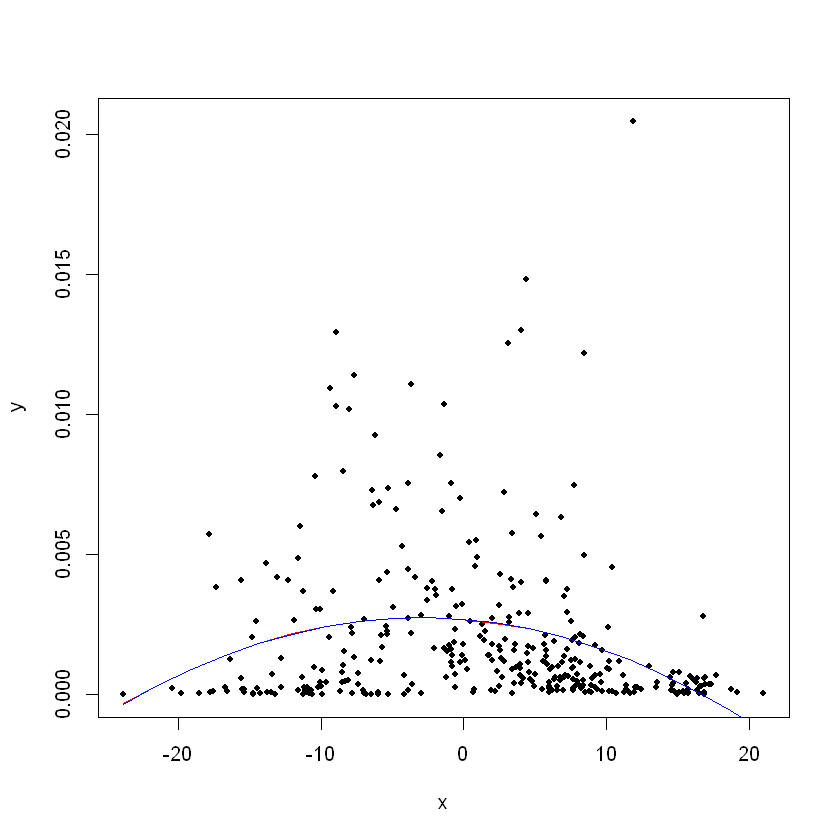

In [137]:
plot(y ~ x, pch = 20)

## This predicts the values for lm model:
x0 <- seq(min(x), max(x), length = 20)  ## prediction grid
y0 <- predict.lm(lm2, newdata = list(x = x0))  ## predicted values
lines(x0, y0, col = 2)

## This predicts the values for Bayesian model:

y0 <-  mean(posterior$alpha) + mean(posterior$beta)*x0 + mean(posterior$beta2)*(x0^2) ## predicted values
lines(x0, y0, col = 4)

#abline( mean(posterior$alpha), mean(posterior$beta), col = 6, lw = 2)

# Now try to replicate the iCAR - spatial random effect model:

In [139]:
write("// Stan model for simple linear regression

data {
  int<lower=0> N; //This represents the number of counties in China
  int<lower=0> N_edges; //Number of edges, i.e. the number of connections between counties
  int<lower=1, upper=N> node1[N_edges];  // node1[i] adjacent to node2[i] 
  int<lower=1, upper=N> node2[N_edges];  // and node1[i] < node2[i]
}
parameters {
  vector[N] phi; // Estimate phi (prior iCar for each county in the dataset)
}
model {
  target += -0.5 * dot_self(phi[node1] - phi[node2]); // 
  // soft sum-to-zero constraint on phi)
  sum(phi) ~ normal(0, 0.01 * N);  // equivalent to mean(phi) ~ normal(0,0.01)
  // sum of all the values in the vector is normally distirbuted with mean 0 and the standard deviation of 0.01*numbe of counties

}",
"stan_models\\buckwheat_simple_icar1.stan")

In [140]:
stan_model <- "stan_models\\buckwheat_simple_icar1.stan"

In [141]:
stan_model

[1] "stan_models\\buckwheat_simple_icar1.stan"

In [142]:
writeLines(readLines(stan_model))


// Stan model for simple linear regression

data {
  int<lower=0> N; //This represents the number of counties in China
  int<lower=0> N_edges; //Number of edges, i.e. the number of connections between counties
  int<lower=1, upper=N> node1[N_edges];  // node1[i] adjacent to node2[i] 
  int<lower=1, upper=N> node2[N_edges];  // and node1[i] < node2[i]
}
parameters {
  vector[N] phi; // Estimate phi (prior iCar for each county in the dataset)
}
model {
  target += -0.5 * dot_self(phi[node1] - phi[node2]); // 
  // soft sum-to-zero constraint on phi)
  sum(phi) ~ normal(0, 0.01 * N);  // equivalent to mean(phi) ~ normal(0,0.01)
  // sum of all the values in the vector is normally distirbuted with mean 0 and the standard deviation of 0.01*numbe of counties

}


In [143]:
str(china)

Formal class 'SpatialPolygonsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	344 obs. of  13 variables:
  .. ..$ ID_0            : Factor w/ 1 level "49": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ ISO             : Factor w/ 1 level "CHN": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ NAME_0          : Factor w/ 1 level "China": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ ID_1            : Factor w/ 31 levels "1","10","11",..: 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ NAME_1          : Factor w/ 31 levels "Anhui","Beijing",..: 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ ID_2            : Factor w/ 344 levels "1","10","100",..: 1 112 223 279 290 301 312 323 334 2 ...
  .. ..$ NAME_2          : Factor w/ 339 levels "Aksu","Altay",..: 5 24 28 37 44 48 69 96 107 109 ...
  .. ..$ TYPE_2          : Factor w/ 5 levels "DÃ¬jÃ­shÃ¬","DÃ¬qu",..: 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ ENGTYPE_2       : Factor w/ 5 levels "Autonomous Prefecture",..: 5 5 5 5 5 5 5 5 5 5 ...
  .. ..$ NL_NAME_2       : Factor w/ 343 levels "å–€ä»€åœ°åŒ

In [302]:
# Gets the numbe of observations
N=nrow(china@data)

# Gets the adjacency
adj<-poly2nb(china)

# Define the nodes as vectors

node2 = vector(mode="numeric");
node1 = vector(mode="numeric");

# Get the values for each node
for (i in 1:N){
    print(i)
    a<-unlist(adj[i])
    a<-a[a>i]
    # Add to values of Node 1
    n1<-rep(i,length(a))
    node1 <-c(node1,n1)
    # Add values of Node 2
    node2<-c(node2,a)
}

# Get the number of edges
N_edges<-length(node1)

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 138
[1] 

In [299]:
class(node1)
class(node2)
class(N_edges)
class(N)

[1] "numeric"

[1] "numeric"

[1] "numeric"

[1] "numeric"

In [300]:
str(node1)

 num [1:1845] 1 1 1 1 1 1 2 2 2 2 ...


In [301]:
str(node2)

 num [1:922] 4 5 12 15 134 180 3 6 9 10 ...


In [297]:
N<-as.numeric(N)
N_edges<-as.numeric(N_edges)

In [276]:
icar_stan = stan_model(stan_model);

In [303]:
fit_stan = sampling(icar_stan, data=list(N,N_edges,node1,node2), control=list(adapt_delta = 0.97, stepsize = 0.1), chains=2, warmup=9000, iter=10000, save_warmup=FALSE);


SAMPLING FOR MODEL 'buckwheat_simple_icar1' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Warmup)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Warmup)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Warmup)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Warmup)
Chain 1: Iteration: 9001 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 421.627 seconds (Warm-up)
Chain 1:                24.831 seconds (Sampling)
Chain 1:    

Warning message:
"There were 2000 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

In [283]:
source("G:\\My Drive\\repos\\example-models\\knitr\\car-iar-poisson\\scotland_data.R")
source("G:\\My Drive\\repos\\example-models\\knitr\\car-iar-poisson\\mungeCARdata4stan.R")

In [284]:
str(data)

List of 7
 $ N      : num 56
 $ y      : num [1:56] 9 39 11 9 15 8 26 7 6 20 ...
 $ E      : num [1:56] 1.4 8.7 3 2.5 4.3 2.4 8.1 2.3 2 6.6 ...
 $ x      : num [1:56] 16 16 10 24 10 24 10 7 7 16 ...
 $ adj    : num [1:264] 5 9 11 19 7 10 6 12 18 20 ...
 $ weights: num [1:264] 1 1 1 1 1 1 1 1 1 1 ...
 $ num    : num [1:56] 4 2 2 3 5 2 5 1 6 4 ...


In [285]:
nbs = mungeCARdata4stan(data$adj, data$num);
N = data$N;
node1 = nbs$node1;
node2 = nbs$node2;
N_edges = nbs$N_edges;

In [294]:
str(N)
str(_)

 num 132


In [287]:
fit_stan = sampling(icar_stan, data=list(N,N_edges,node1,node2), control=list(adapt_delta = 0.97, stepsize = 0.1), chains=2, warmup=9000, iter=10000, save_warmup=FALSE);


SAMPLING FOR MODEL 'buckwheat_simple_icar1' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Warmup)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Warmup)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Warmup)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Warmup)
Chain 1: Iteration: 9001 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 11.57 seconds (Warm-up)
Chain 1:                1.224 seconds (Sampling)
Chain 1:            

In [306]:
fit_stan
posterior <- rstan::extract(fit_stan)
str(posterior)

Inference for Stan model: buckwheat_simple_icar1.
2 chains, each with iter=10000; warmup=9000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

             mean se_mean       sd      2.5%       25%      50%      75%
phi[1]       0.76    0.32     0.41     -0.10      0.48     0.78     1.14
phi[2]      -0.11    0.90     0.92     -1.37     -1.03    -0.09     0.70
phi[3]       0.09    1.27     1.27     -1.44     -1.18     0.14     1.31
phi[4]       0.06    0.81     0.82     -0.99     -0.75     0.16     0.83
phi[5]       0.67    0.85     0.87     -0.58     -0.14     0.69     1.45
phi[6]      -0.05    1.26     1.26     -1.57     -1.32     0.07     1.22
phi[7]       0.70    0.62     0.65     -0.27      0.05     0.81     1.30
phi[8]      -0.34    1.32     1.33     -2.14     -1.62    -0.25     0.98
phi[9]      -0.43    1.22     1.26     -1.96     -1.68    -0.53     0.90
phi[10]      0.53    0.79     0.81     -0.66     -0.25     0.56     1.31
phi[11]      0.55    0.96   

List of 2
 $ phi : num [1:2000, 1:344] 0.673 0.265 0.298 0.965 0.571 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ iterations: NULL
  .. ..$           : NULL
 $ lp__: num [1:2000(1d)] -168 -168 -170 -174 -191 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL


In [321]:
mean(posterior$phi[,2])

[1] -0.1090638

In [322]:
save(fit_stan, file="stan_models\\buckwheat_simple_icar1.R")

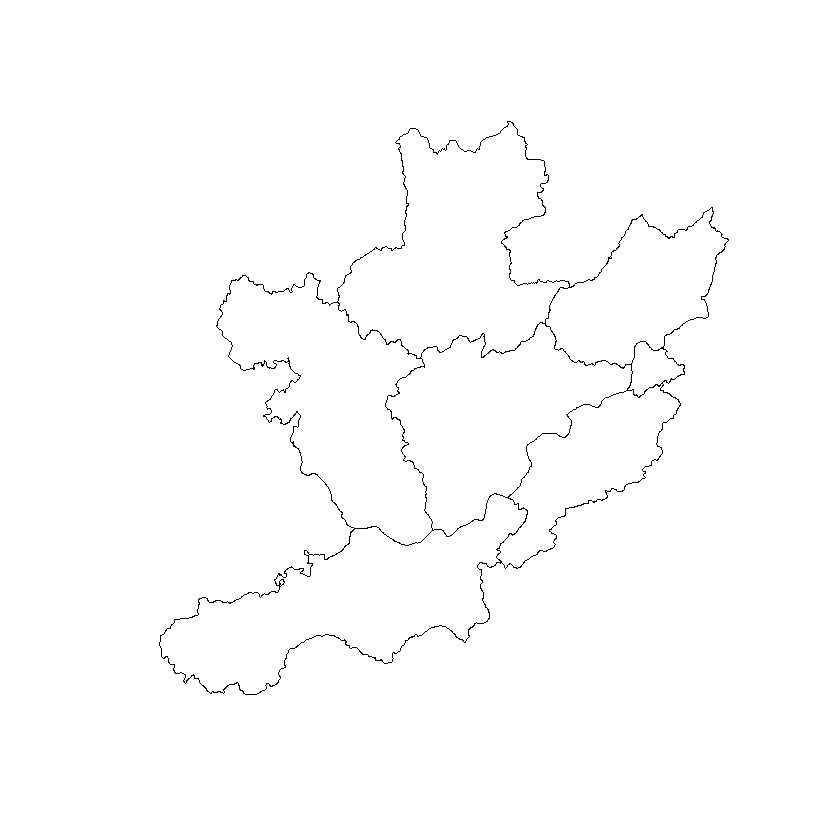

In [168]:
plot(subset(china,china@data$ID_2 %in% c(1,4,5,12,15,134,180)))